# Project Description
Pyschologists have developed a measure of the intellectual complexity of a written document based on its awareness of the possibility of multiple viewpoints and depth of content. This metric for speech is known as **integrative complexity**.

Political scientists have applied this measure to the state of the union speeches from U.S. presidents over the last 200 years. The score appears as a value between 0 and 4, with the majority of speeches being in the range of 1-2. 

Generating integrative complexity scores has a natural bottleneck, as it requires multiple human scorers for each document. 

The goal of this project is to see whether integrative complexity can be predicted from word frequencies. The dataset we will be using includes the original speech documents, as well as a document-word matrix. 

## Approach
We will follow a common approach for most data science projects.
1. Exploratory Data Analysis
2. Establish a Common Sense Baseline
2. Feature Generation
3. Model Testing
4. Hyperparameter Tuning
5. Ensemble Methods

# Exploratory Data Analysis
First, lets bring our data in. The data was provided as part of the course assignment, and so we will be learning together what their contents are! We have several data documents:

- **rownnormalizeddocword.csv**: The document-word matrix. Each row corresponds to one speech, and each column a word in the vocabulary of our dataset. At present, I am unsure what the effect of the data being *normalized* refers to.
- **speechdetails.csv**: Presumably some metadata with greater context about the speech and it's topic (we can assume speaker, year, and most importantly its integrative complexity score). 
- **presidentspeeches (folder)**: This folder contains the original source text for each of the speeches. This will be useful to dive into so we can generate our own text-based features.

## Imports

In [1]:
import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
datapath = '../data'
os.listdir(datapath)

['speechdetails.csv', 'rownormaliseddocword.csv', 'presidentspeeches']

### Speech Details

In [3]:
sd_df = pd.read_csv('../data/speechdetails.csv')
sd_df.head()

,Name,Year,File number,IC
0,G. Washington,1790,1,2.10
1,G. Washington,1790,2,2.00
2,G. Washington,1791,3,1.75
3,G. Washington,1792,4,1.40
4,J. Adam,1797,9,2.50


As expected, the speech details file contains the speaker, year, file number, and integrated complexity score. Let's dive deeper.

In [4]:
sd_df.describe()

,Year,File number,IC
count,148.000000,148.000000,148.000000
mean,1893.837838,105.256757,1.767227
std,60.897712,60.100610,0.413446
min,1790.000000,1.000000,1.000000
25%,1845.750000,57.750000,1.500000
50%,1887.500000,99.500000,1.750000
75%,1947.250000,158.250000,2.000000
max,2004.000000,213.000000,3.750000


In [5]:
sd_df.isnull().sum()

Name           0
Year           0
File number    0
IC             0
dtype: int64

There are a number of plots we should create to gain more insight:
- Integrated complexity over time
- Average integrated complexity per time period
- Average integrated complexity per speaker
### Plotting

In [6]:
sd_df.columns

Index(['Name', 'Year', 'File number', 'IC'], dtype='object')

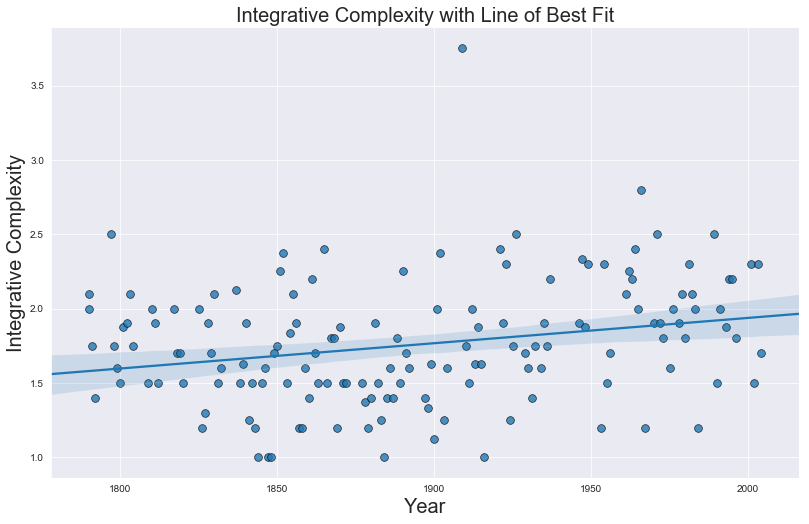

In [9]:
#Scatter plot w/ LR line of best fit

# Plot
sns.set_style("darkgrid")
gridobj = sns.lmplot(x='Year', y='IC', data=sd_df, 
                     height=7, aspect=1.6, robust=True, palette='tab10', 
                     scatter_kws=dict(s=60, linewidths=.7, edgecolors='black'))

# Decorations
plt.title("Integrative Complexity with Line of Best Fit", fontsize=20)
plt.xlabel('Year',fontsize=20)
plt.ylabel('Integrative Complexity',fontsize=20)
plt.show()

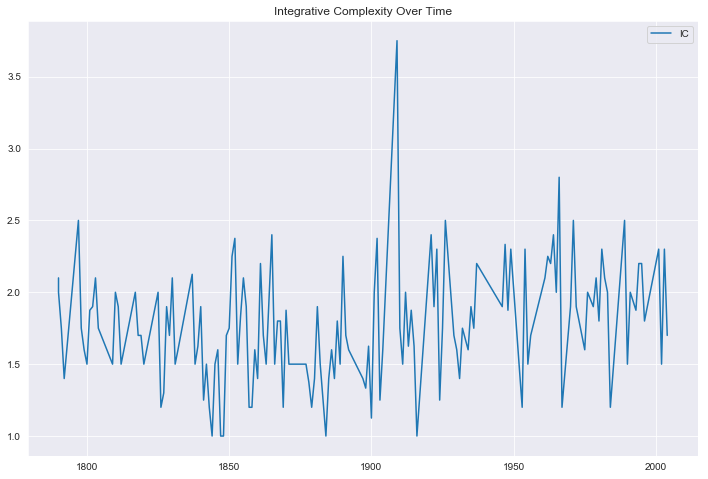

In [10]:
#Integrative complexity over time
fig = plt.figure(figsize=(12,8))
ax = plt.axes()

years = sd_df.Year.values
ics = sd_df.IC.values

ax.plot(years, ics, label = 'IC')

plt.title('Integrative Complexity Over Time')
ax.legend()
plt.show()

In [11]:
print('Minimum IC:',min(ics))
print('Maximum IC:',max(ics))

Minimum IC: 1.0
Maximum IC: 3.75


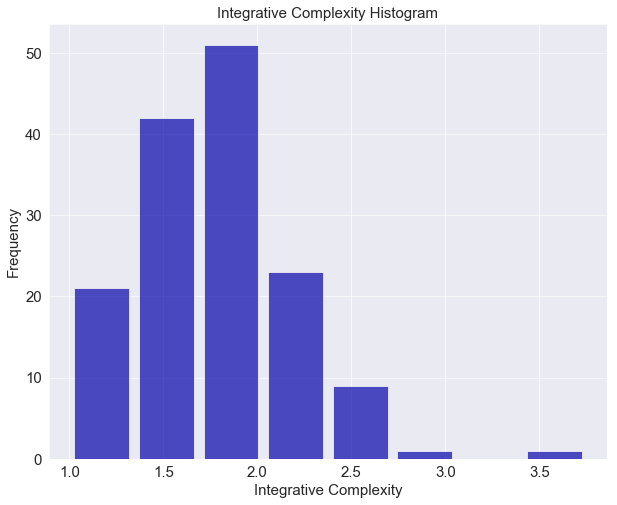

In [12]:
#IC Histogram

plt.figure(figsize=[10,8])
n, bins, patches = plt.hist(x=ics, bins=8, color='#0504aa',alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Integrative Complexity',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.title('Integrative Complexity Histogram',fontsize=15)
plt.show()

In [34]:
#Average IC by speaker
speaker_means = sd_df.groupby('Name').mean().sort_values(['IC'], ascending=False)
speaker_means.head()

,Year,File number,IC
Name,,,
W.Taft,1910.5,122.5,2.250000
J.Kennedy,1962.0,173.0,2.183333
W.Harding,1921.5,133.5,2.150000
M.Fillmore,1851.0,63.0,2.125000
H.Trueman,1947.5,158.5,2.102000


Notes:
- Stationarity test
- Remove seasonal trends

## Document Word CSV

In [37]:
dw_df = pd.read_csv('../data/rownormaliseddocword.csv',header=None)
dw_df.head()

,0,1,2,3,4,5,6,7,8,9,...,2991,2992,2993,2994,2995,2996,2997,2998,2999,3000
0,0.028754,0.022364,0.019169,0.019169,0.017572,0.017572,0.017572,0.015974,0.014377,0.014377,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.10
1,0.025852,0.015276,0.021152,0.003525,0.017626,0.009401,0.012926,0.019976,0.022327,0.007050,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.00
2,0.029231,0.017692,0.013077,0.004615,0.020769,0.004615,0.012308,0.003846,0.023077,0.006923,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.75
3,0.025726,0.018257,0.009958,0.006639,0.016598,0.014938,0.006639,0.009129,0.009958,0.005809,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.40
4,0.007843,0.006274,0.022745,0.004706,0.008627,0.007843,0.003137,0.014902,0.010980,0.003137,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.50


In the assignment outline text file, it mentions a normalization process for a word-document frequency matrix. In this normalization technique, the count values/frequencies in each row are divided by the sum of frequencies in that row. More semantically, we can understand this to mean that the value in each entry is divided by the word count of its corresponding row/document.

We will leave the exploration of the text files to another notebook